In [1]:
from Librerias import *
from catboost import  Pool
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
df=pd.read_csv('Wallapop_Definitivo_Coordenadas.csv')

In [3]:
def busca_averia(df):
    # Inicializar la columna 'Palabras clave' en 0
    df['Averia'] = 0
    
    # Lista de palabras clave
    lista_palabras = ['aver', 'roto',"no funciona","para piezas","desperfecto","fallo","rotura","error","defect","malfuncionamiento","sinies","sinestro"]  # Puedes añadir más palabras clave aquí
    
    # Definir una función para buscar palabras clave en los comentarios
    def contiene_palabras_clave(comentario):
        comentario = str(comentario).lower()
        for palabra in lista_palabras:
            if palabra in comentario:
                return 1           
        return 0   
    # Aplicar la función solo a las filas donde 'Tipo de vehiculo' es 'Furgoneta'
    df.loc[df['Tipo de vehiculo'] != 'asd', 'Averia'] = df[df['Tipo de vehiculo'] != 'asd']['Comentarios'].apply(contiene_palabras_clave) 
    return df

In [4]:
def busca_camper(df):
    # Inicializar la columna 'Palabras clave' en 0
    df['Camper'] = 0
    
    # Lista de palabras clave
    lista_palabras = ['camper', 'casa']  # Puedes añadir más palabras clave aquí
    
    # Definir una función para buscar palabras clave en los comentarios
    def contiene_palabras_clave(comentario):
        comentario = str(comentario).lower()
        for palabra in lista_palabras:
            if palabra in comentario:
                return 1
        return 0
    
    # Aplicar la función solo a las filas donde 'Tipo de vehiculo' es 'Furgoneta'
    df.loc[df['Tipo de vehiculo'] == 'Furgoneta', 'Camper'] = df[df['Tipo de vehiculo'] == 'Furgoneta']['Comentarios'].apply(contiene_palabras_clave) 
    return df

In [5]:
def marca_lujo(df):
    marcas_de_lujo = [
        'MERCE', 'BMW', 'AUDI', 'PORSCHE', 'JAGUAR', 'LEXUS', 'TESLA', 
        'MASERATI', 'ASTON MARTIN', 'CADILLAC', 'INFINITI', 'ALFA ROMEO', 
        'ROVER']
    # Crear la columna 'es_de_lujo'
    df['Lujo'] = df['Marca'].isin(marcas_de_lujo)
    
    return df

In [ ]:
df = busca_averia(df)
df = busca_camper(df)
df = marca_lujo(df)

In [8]:
# train-test split
X=df.drop(columns=['Comentarios',"Modelo", 'Nombre usuario', 'Puntuacion', 'Nº Ventas', 'Ubicacion', 'Precio',"longitud","latitud"])
y=np.log(df['Precio'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)  # random_state=42

xtrain_normal=X_train.copy()
xtest_normal=X_test.copy()

In [9]:
def pre_model(X_train, X_test):
    
    columnas_cat=['Marca', 'Tipo de vehiculo', 'Combustible', 'Cambio',]  #'Antigüedad', 'Potencia', 'Año'
    objeto_dummies = OneHotEncoder(sparse_output=False, #por defecto el formato el formato es sparse
                                drop='first', # no creamos una nueva columna con la primera categoria que encuentra
                                handle_unknown='ignore') # ignora nuevas categorias en el test
    
    objeto_dummies.fit(X_train[columnas_cat])
    objeto_dummies.transform(X_train[columnas_cat])

    nombre_columnas= objeto_dummies.get_feature_names_out(columnas_cat)

    X_train[nombre_columnas] = objeto_dummies.transform(X_train[columnas_cat])
    X_train = X_train.drop(columns=columnas_cat)

    X_test[nombre_columnas] = objeto_dummies.transform(X_test[columnas_cat])
    X_test=X_test.drop(columns=columnas_cat)
    
    return X_train, X_test

In [10]:
X_train, X_test, = pre_model(X_train, X_test)

[0]	validation_0-rmse:0.75043	validation_1-rmse:0.74633
[1]	validation_0-rmse:0.74523	validation_1-rmse:0.74124
[2]	validation_0-rmse:0.73929	validation_1-rmse:0.73536
[3]	validation_0-rmse:0.73341	validation_1-rmse:0.72953
[4]	validation_0-rmse:0.72757	validation_1-rmse:0.72371
[5]	validation_0-rmse:0.72253	validation_1-rmse:0.71868
[6]	validation_0-rmse:0.71760	validation_1-rmse:0.71386
[7]	validation_0-rmse:0.71199	validation_1-rmse:0.70832
[8]	validation_0-rmse:0.70858	validation_1-rmse:0.70493
[9]	validation_0-rmse:0.70302	validation_1-rmse:0.69942
[10]	validation_0-rmse:0.69821	validation_1-rmse:0.69463
[11]	validation_0-rmse:0.69355	validation_1-rmse:0.68999
[12]	validation_0-rmse:0.68816	validation_1-rmse:0.68464
[13]	validation_0-rmse:0.68282	validation_1-rmse:0.67936
[14]	validation_0-rmse:0.67823	validation_1-rmse:0.67480
[15]	validation_0-rmse:0.67545	validation_1-rmse:0.67203
[16]	validation_0-rmse:0.67254	validation_1-rmse:0.66919
[17]	validation_0-rmse:0.66734	validation

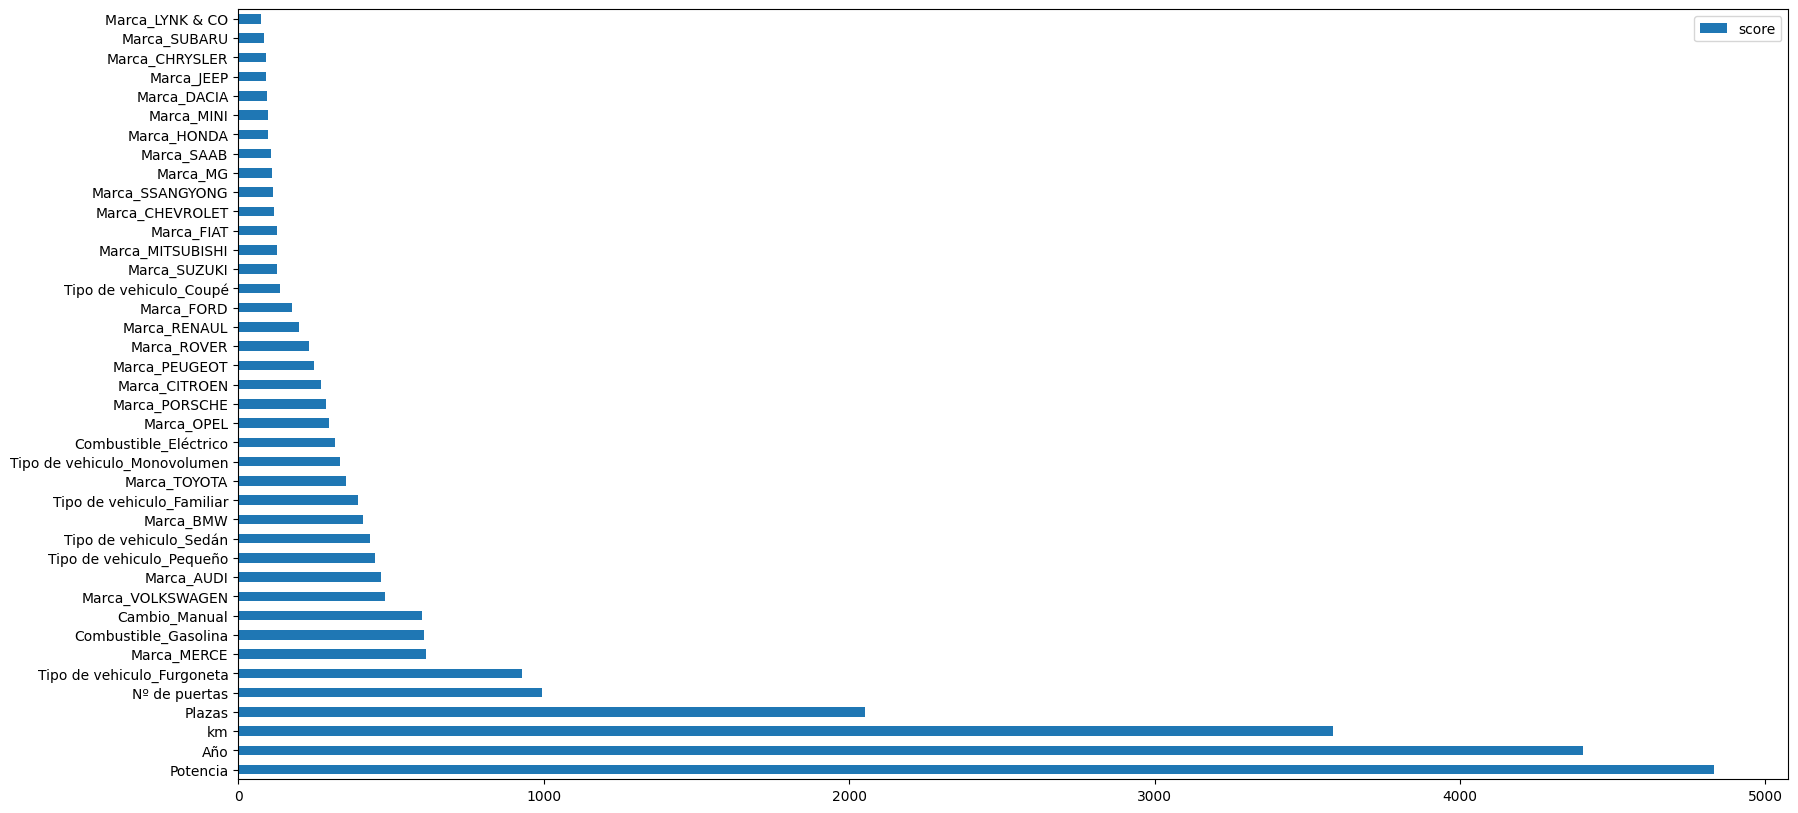

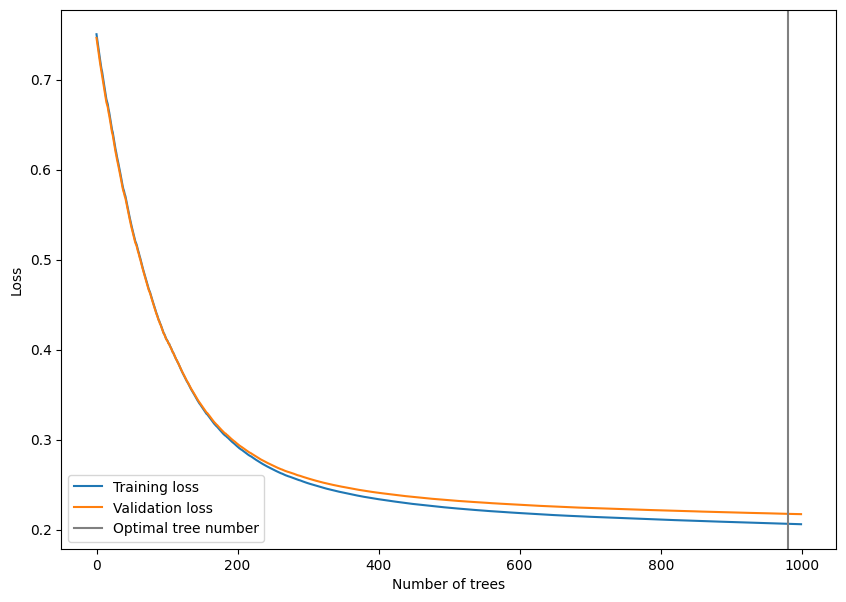

In [12]:
xgbmodel = XGBRegressor()

model = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01,
                         reg_lambda= 0.1, min_child_weight=2, gamma=0.1,
                         subsample=0.8,colsample_bytree=0.7,
                        reg_alpha=0.01, early_stopping_rounds=10)
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])


results = model.evals_result()
total_trees=len(results["validation_0"]["rmse"]) #el numero total de arboles

yhat_train=model.predict(X_train)
yhat_test=model.predict(X_test)

print(r2_score(y_train,yhat_train))
print(r2_score(y_test, yhat_test))

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(total_trees-20, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [13]:
def ver_error(xtrain_normal,xtest_normal,y_train,y_test,yhat_train,yhat_test): #Creamos otra columnas con la predicccion y el error normal/absoluto

    df_train = pd.concat([xtrain_normal, np.exp(y_train)], axis=1)
    df_test = pd.concat([xtest_normal, np.exp(y_test)],axis=1)
    df_train['Prediccion']=np.exp(yhat_train)
    df_test['Prediccion']=np.exp(yhat_test)
    df_final=pd.concat([df_train,df_test],axis=0)
    df_final['Error']=df_final['Prediccion']-df_final['Precio']
    
    return df_final

In [14]:
df_final=ver_error(xtrain_normal,xtest_normal,y_train,y_test,yhat_train,yhat_test)


In [15]:
df_final['Error'].describe()

count    50355.000000
mean      -437.210940
std       3601.016523
min     -29113.417969
25%      -1899.096680
50%         -8.066406
75%       1522.295898
max      14797.210938
Name: Error, dtype: float64

In [16]:
df_final['AbsError'] = df_final['Error'].abs()

In [17]:
df_final_sorted = df_final.sort_values(by='AbsError',ascending=False) ##Ordenamos los errores
df_error=df_final_sorted.head(1000)

In [18]:
df_error ## Ordenamos el df por donde los valores tienen más errores y a futuro tratar de mejorar esto

,Marca,Año,Potencia,Plazas,Nº de puertas,km,Tipo de vehiculo,Combustible,Cambio,Precio,Prediccion,Error,AbsError
48261,PEUGEOT,2016,130,4,4,115000,Furgoneta,Diésel,Manual,50000.0,20886.582031,-29113.417969,29113.417969
42232,CITROEN,2016,130,3,4,166000,Furgoneta,Diésel,Manual,45000.0,17859.039062,-27140.960937,27140.960937
49682,PEUGEOT,2015,130,4,4,266000,Furgoneta,Diésel,Manual,41500.0,15253.679688,-26246.320312,26246.320312
49754,CITROEN,2016,130,4,5,220000,Furgoneta,Diésel,Manual,42000.0,16487.875000,-25512.125000,25512.125000
42252,PEUGEOT,2016,130,2,4,68000,Furgoneta,Diésel,Manual,44500.0,18998.343750,-25501.656250,25501.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42193,TOYOTA,2014,286,7,5,190000,4x4,Diésel,Automático,45000.0,34757.582031,-10242.417969,10242.417969
48153,PORSCHE,2016,385,5,5,168000,4x4,Diésel,Automático,49900.0,39660.343750,-10239.656250,10239.656250
2803,JEEP,2001,121,4,2,149000,4x4,Gasolina,Manual,17899.0,7665.387695,-10233.612305,10233.612305
47614,VOLKSWAGEN,2018,150,4,4,61000,Furgoneta,Diésel,Manual,46000.0,35766.500000,-10233.500000,10233.500000
